<center>
    <h1>Artificial Neural Networks</h1>
    <h2>by Rebecca Hinrichs</h2>
    <h4>8 Mar 23</h4>
</center>

---
<h3>Part 1: Describe Batch Normalization</h3><br>

Batch Normalization is a technique applied to a layer in an Artifical Neural Network model in which it normalizes the previous layer called (sets the mean to near-zero) so that the distribution of the layer would be fed to the next layer as efficiently as possible while maintaining the integrity of the raw data (not applying any transformations to the data values in the layers). The Batch Normalization layer achieves this by summing the batch outputs and subtracting the batch mean, and then dividing the result by the batch's standard deviation. This interim product between the layers (the Batch Normalization layer) protects data integrity while retaining its transformation values before feeding the model to the next layer. In addition to this normalization process, the calculations are performed in batches of input data rather than a single data input at a time. Since the next layer "knows" what to expect because the data has been normalized, the model is able to implement its learning rate at a much faster rate computationally, effectively implementing a batch stochastic gradient as it travels layer to layer and re-distributing each layer's inputs along the way (if applied after subsequent layers). It ensures each batch submitted is random and not influencing subsequent batches in that layer in that epoch. In other words, it ensures linear independence (low correlation), a key mandate of building a proper prediction model with translatable weights and biases to future data.

---
### Part 2: Load MNIST Fashion Data Set from keras
https://keras.io/api/datasets/fashion_mnist/ <br>
Create several neural network models investigating the effect of hyperparameters and
techniques we studied on the model performance (number of layers, number of neurons in
hidden layers, optimizers, batch size and learning rate in the gradient descent optimizers,
L1 and L2 regularization, dropout, batch normalization, weight and bias initialization,
etc.) using the information provided at https://keras.io/api/

In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import numpy as np

# Import ML Libraries
from tensorflow.keras import models, datasets, layers, optimizers

# Import Dataset as Training/Test sets
(X_train_full, y_train_full), (X_test, y_test) = datasets.fashion_mnist.load_data()
print(f'Training data shape :: {X_train_full.shape}\nTesting data shape :: {X_test.shape}')

Training data shape :: (60000, 28, 28)
Testing data shape :: (10000, 28, 28)


In [2]:
# Reserve part of the training set for cross-validation
boundary = 50000
X_train, X_valid = X_train_full[:boundary], X_train_full[boundary:]
y_train, y_valid = y_train_full[:boundary], y_train_full[boundary:]
print(f'\nTraining data shape :: {X_train.shape}\nCross-training validation data shape :: {X_valid.shape}\n')


Training data shape :: (50000, 28, 28)
Cross-training validation data shape :: (10000, 28, 28)



---
### EDA

In [40]:
# Describe the classifiers
label_descriptors = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
                     'Sandal','Shirt','Sneaker','Bag','Ankle boot']  # https://keras.io/api/datasets/fashion_mnist/
print(f' <Label>\t<Descriptor>')
for _ in range(len(set(y_train_full))):
    print(f'{np.unique(y_train_full)[_]:>5}\t\t{label_descriptors[_]:<10}')

 <Label>	<Descriptor>
    0		T-shirt/top
    1		Trouser   
    2		Pullover  
    3		Dress     
    4		Coat      
    5		Sandal    
    6		Shirt     
    7		Sneaker   
    8		Bag       
    9		Ankle boot


In [4]:
# Observe percentage of label distribution per training / testing samples
print('\n<< ---------- PRESENTING CLASS DISTRIBUTIONS ---------- >> \n')
print(f'Total samples in dataset: {len(X_train_full)+len(X_test)} grayscale images\n')
unique, frequency = np.unique(y_train, return_counts = True)
print(f'Class distribution for {len(y_train)} training samples:')
print(f'Label\tCount\tPercent')
for u, f in zip(unique, frequency):
    print(f'{u:>5}\t{f:>5}\t{f/frequency.sum():.1%}')
print()
unique, frequency = np.unique(y_valid, return_counts = True)
print(f'Class distribution for {len(y_valid)} cross-training validation samples:')
print(f'Label\tCount\tPercent')
for u, f in zip(unique, frequency):
    print(f'{u:>5}\t{f:>5}\t{f/frequency.sum():.1%}')
print()
unique, frequency = np.unique(y_test, return_counts = True)
print(f'Class distribution for {len(y_test)} testing samples:')
print(f'Label\tCount\tPercent')
for u, f in zip(unique, frequency):
    print(f'{u:>5}\t{f:>5}\t{f/frequency.sum():.1%}')
print()


<< ---------- PRESENTING CLASS DISTRIBUTIONS ---------- >> 

Total samples in dataset: 70000 grayscale images

Class distribution for 50000 training samples:
Label	Count	Percent
    0	 4977	10.0%
    1	 5012	10.0%
    2	 4992	10.0%
    3	 4979	10.0%
    4	 4950	9.9%
    5	 5004	10.0%
    6	 5030	10.1%
    7	 5045	10.1%
    8	 5032	10.1%
    9	 4979	10.0%

Class distribution for 10000 cross-training validation samples:
Label	Count	Percent
    0	 1023	10.2%
    1	  988	9.9%
    2	 1008	10.1%
    3	 1021	10.2%
    4	 1050	10.5%
    5	  996	10.0%
    6	  970	9.7%
    7	  955	9.6%
    8	  968	9.7%
    9	 1021	10.2%

Class distribution for 10000 testing samples:
Label	Count	Percent
    0	 1000	10.0%
    1	 1000	10.0%
    2	 1000	10.0%
    3	 1000	10.0%
    4	 1000	10.0%
    5	 1000	10.0%
    6	 1000	10.0%
    7	 1000	10.0%
    8	 1000	10.0%
    9	 1000	10.0%



Ankle boot


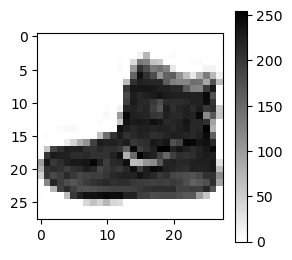

In [5]:
# Demonstrate a single array of input 'x' values as a 28 x 28 grayscale image
plt.figure(figsize=(3, 3))
plt.imshow(X_train[0], cmap='binary')
plt.colorbar()
print(label_descriptors[y_train[0]]);

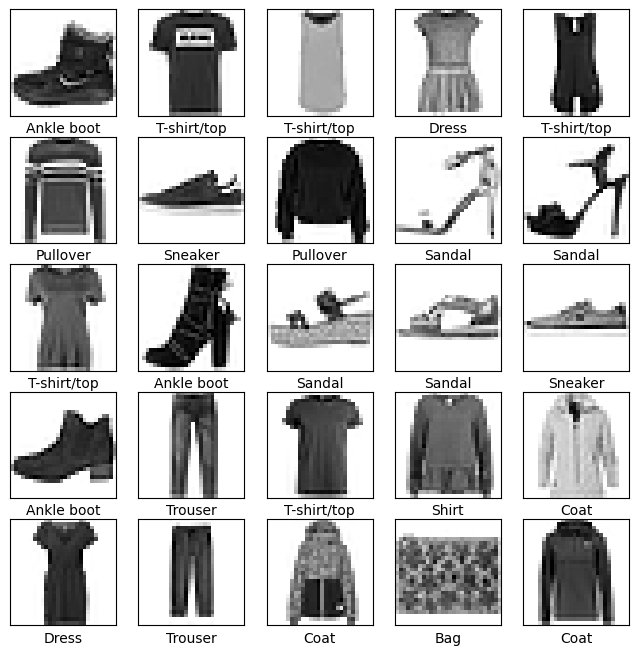

In [6]:
# Demonstrate a 5 x 5 grid sample of classification images
plt.figure(figsize=(8, 8))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i], cmap='binary')
  plt.xlabel(label_descriptors[y_train[i]])
  plt.xticks([])
  plt.yticks([]);

---
### Normalization

In [7]:
# Scale values in all X arrays respectively (grayscale = 255 integers)
scalar = X_train.max()
X_train = X_train/scalar
X_valid = X_valid/scalar
X_test = X_test/scalar

# Check a random vector to ensure it worked
print(f'\nValues in X_train are from {X_train.min()} to {X_train.max()}\n')
X_train[np.random.choice(X_train[0].shape[0], 1, replace=False)][0][4]


Values in X_train are from 0.0 to 1.0



array([0.        , 0.        , 0.        , 0.        , 0.09803922,
       0.76078431, 0.70588235, 0.69803922, 0.68235294, 0.72156863,
       0.73333333, 0.74117647, 0.73333333, 0.72156863, 0.70980392,
       0.74117647, 0.78431373, 0.77254902, 0.75686275, 0.74509804,
       0.69803922, 0.68627451, 0.76078431, 0.35294118, 0.        ,
       0.        , 0.        , 0.        ])

Ankle boot


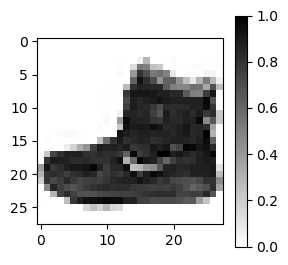

In [8]:
# Demonstrate scaled array of input 'x' values as a 28 x 28 grayscale image
plt.figure(figsize=(3, 3))
plt.imshow(X_train[0], cmap='binary')
plt.colorbar()
print(label_descriptors[y_train[0]]);

---
### Train & Test Model

In [9]:
# Record the number of class labels
label_count = len(set(y_train))

---
   - Model 1 :: single layer

In [10]:
# Instantiate the ANN Model using a single flattened input and output layer
model1 = models.Sequential(                                     # each layer has 1 input tensor, 1 output tensor
    [layers.Flatten(input_shape=(28, 28), name='input'),        # to build weights; transforms 2-D to 1-D array
                          layers.Dense(units=label_count,       # creates a single output layer for ea class
                                       activation='softmax',    # 'softmax' is required for one output per label
                                       name='output')           # identity of class-size output layer
], name='Sequential_Model_1')
# Configure the model for training
model1.compile(optimizer='adam',                        # combining momentum & adadelta to update model
              loss='sparse_categorical_crossentropy',   # because our labels are integers
              metrics=['accuracy']                      # metric specification for classification
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model1.weights))
model1.summary()

Number of weights after calling the model: 2
Model: "Sequential_Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Fit the training model with 5 iterations and display the final results
model1.fit(X_train, y_train, epochs=5, verbose=0)

# Observe the fitted model figures
loss1, accuracy1 = model1.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model_1 presents {round(loss1*100,2)}% loss and {round(accuracy1*100,2)}% accuracy.')


Sequential_Model_1 presents 40.2% loss and 86.11% accuracy.


We will consider this our BASELINE MODEL and will attempt to improve accuracy and decrease loss.

---
   - Model 2 :: increase iterations

In [12]:
# Instantiate another ANN Model using a higher iteration count
model2 = models.Sequential([
    layers.Flatten(input_shape=(28, 28), name='input'),
    layers.Dense(label_count, activation='softmax', name='output')     # output multi-class layer using 'softmax'
], name='Sequential_Model_2')
# Configure the model for training
model2.compile(optimizer='adam',                        # combining momentum & adadelta to update model
              loss='sparse_categorical_crossentropy',   # because our labels are integers
              metrics=['accuracy']                      # metric specification for classification
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model2.weights))
model2.summary()

Number of weights after calling the model: 2
Model: "Sequential_Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Fit the training model with 100 iterations and display the final results
model2.fit(X_train, y_train, epochs=100, verbose=0)

# Observe the fitted model figures
loss2, accuracy2 = model2.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model_2 presents {round(loss2*100,2)}% loss and {round(accuracy2*100,2)}% accuracy.\n')


Sequential_Model_2 presents 33.73% loss and 88.14% accuracy.



Increasing our iteration count has reduced loss and only slightly improved accuracy.

---
   - Model 3 :: add hidden layer

In [18]:
# Instantiate another ANN Model with an additional layer
model3 = models.Sequential([
    layers.Flatten(input_shape=(28, 28), name='input'),
    layers.Dense(64, activation='relu', name='middle_layer'),         # hidden 128-neuron layer using 'relu'
    layers.Dense(label_count, activation='softmax', name='output')     # output multi-class layer using 'softmax'
], name='Sequential_Model_3')
# Configure the model for training
model3.compile(optimizer='adam',                        # combining momentum & adadelta to update model
              loss='sparse_categorical_crossentropy',   # because our labels are integers
              metrics=['accuracy']                      # metric specification for classification
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model3.weights))
model3.summary()

Number of weights after calling the model: 4
Model: "Sequential_Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 middle_layer (Dense)        (None, 64)                50240     
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit the training model with 10 iterations and display the results
model3.fit(X_train, y_train, epochs=10, verbose=0)

# Observe the fitted model figures
loss3, accuracy3 = model3.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model_3 presents {round(loss3*100,2)}% loss and {round(accuracy3*100,2)}% accuracy.\n')


Sequential_Model_3 presents 25.03% loss and 90.58% accuracy.



Adding a hidden layer has improved both loss and accuracy.

---
   - Model 4 :: increase layer complexity

In [31]:
# Instantiate another ANN Model using additional hidden layers
model4 = models.Sequential([
    layers.Flatten(input_shape=(28, 28), name='input'),
    layers.Dense(512, activation='relu', name='layer1'),              # hidden 512-neuron layer using 'relu'
    # layers.Dense(256, activation='relu', name='layer2'),              # hidden 256-neuron layer using 'relu'
    # layers.Dense(128, activation='relu', name='layer3'),              # hidden 128-neuron layer using 'relu'
    # layers.Dense(128, activation='relu', name='layer3b'),             # hidden 128-neuron layer using 'relu'
    # layers.Dense(64, activation='relu', name='layer4'),               # hidden 64-neuron layer using 'relu'
    layers.Dense(label_count, activation='softmax', name='output')    # output multi-class layer using 'softmax'
], name='Sequential_Model_4')
# Configure the model for training
model4.compile(optimizer='adam',                        # combining momentum & adadelta to update model
              loss='sparse_categorical_crossentropy',   # because our labels are integers
              metrics=['accuracy']                      # metric specification for classification
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model4.weights))
model4.summary()

Number of weights after calling the model: 4
Model: "Sequential_Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 512)               401920    
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Fit the training model with 10 iterations and display the final results
model4.fit(X_train, y_train, epochs=10, verbose=0)

# Observe the fitted model figures
loss4, accuracy4 = model4.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model_4 presents {round(loss4*100,2)}% loss and {round(accuracy4*100,2)}% accuracy.\n')


Sequential_Model_4 presents 19.91% loss and 92.64% accuracy.



Introducing more layers did not significantly improve our model, but increasing the number of neurons in our hidden layer has improved our statistics. We will check this model for overfitting...

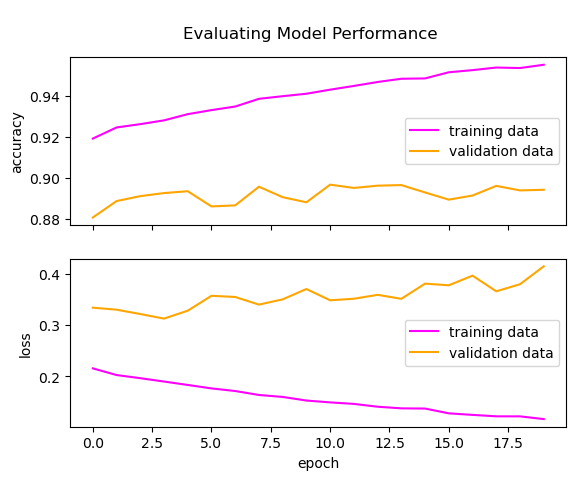

In [33]:
# Fit the cross-training validation model with 20 iterations
validate = model4.fit(X_train, y_train, epochs=20, verbose=0, validation_data=(X_valid, y_valid))

# Compare training and cross-training performance metrics
acc = validate.history['accuracy']           # training accuracy
val_acc = validate.history['val_accuracy']   # validation accuracy

loss = validate.history['loss']              # training loss
val_loss = validate.history['val_loss']      # validation loss

# Create subplot demonstration of model performance
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('\nEvaluating Model Performance')

# Demonstrate model accuracy between training & validation data :: goal is increased accuracy
axs[0].plot(acc, label='training data', color='magenta')
axs[0].plot(val_acc, label='validation data', color='orange')
axs[0].set(ylabel='accuracy')
axs[0].legend()

# Demonstrate model loss between training & validation data :: goal is decreased loss
axs[1].plot(loss, label='training data', color='magenta')
axs[1].plot(val_loss, label='validation data', color='orange')
axs[1].set(xlabel='epoch')
axs[1].set(ylabel='loss')
axs[1].legend();

We observe a significantly lower accuracy on the validation data, and increasing loss per epoch. Therefore this model may be overfitting the data. We will attempt finding a better model using additional methods.

---
   - Model 5 :: utilizing Batch Normalization & Dropout

In [10]:
# Instantiate another layer in a complex ANN Model utilizing Batch Normalization & Dropout
model5 = models.Sequential([
    layers.Flatten(input_shape=(28, 28), name='input'),   
    layers.Dense(128, activation='relu', name='layer1'),
    layers.BatchNormalization(name='batch_norm_layer1'),        # batch-normalize previous layer
    layers.Dropout(0.2, name='removal_layer1'),          # remove 50% of the layer's neurons per iteration  
    layers.Dense(128, activation='relu', name='layer2'),
    layers.BatchNormalization(name='batch_norm_layer2'),        # batch-normalize previous layer
    layers.Dropout(0.2, name='removal_layer2'),          # remove 50% of the layer's neurons per iteration   
    layers.Dense(label_count, activation='softmax', name='output')    # output multi-class layer using 'softmax'
], name='Sequential_Model_5')
# Configure the model for training
model5.compile(optimizer='adam',                        # combining momentum & adadelta to update model
              loss='sparse_categorical_crossentropy',   # because our labels are integers
              metrics=['accuracy']                      # metric specification for classification
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model5.weights))
model5.summary()

Number of weights after calling the model: 14
Model: "Sequential_Model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 128)               100480    
                                                                 
 batch_norm_layer1 (BatchNor  (None, 128)              512       
 malization)                                                     
                                                                 
 removal_layer1 (Dropout)    (None, 128)               0         
                                                                 
 layer2 (Dense)              (None, 128)               16512     
                                                                 
 batch_norm_layer2 (BatchNor  (None, 128)              512       
 m

In [11]:
# Fit the training model with 70 iterations and display the final results
model5.fit(X_train, y_train, epochs=70, verbose=0)

# Observe the fitted model figures
loss5, accuracy5 = model5.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model_5 presents {round(loss5*100,2)}% loss and {round(accuracy5*100,2)}% accuracy.\n')


Sequential_Model_5 presents 18.79% loss and 93.06% accuracy.



Introducing Batch Normalization & Dropout seems to have improved model performance. We're going to test it against the validation data with a batch size of 64 as a parameter and decreasing the number of iterations.

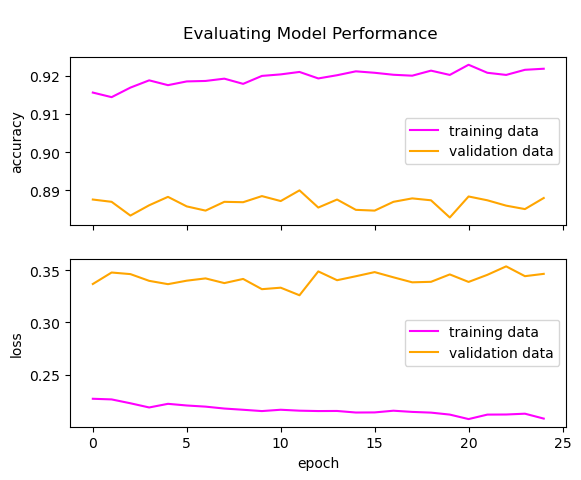

In [13]:
# Fit the cross-training validation model with 25 iterations
validate = model5.fit(X_train, y_train, epochs=25, batch_size=64, verbose=0, 
                      validation_data=(X_valid, y_valid))

# Compare training and cross-training performance metrics
acc = validate.history['accuracy']           # training accuracy
val_acc = validate.history['val_accuracy']   # validation accuracy

loss = validate.history['loss']              # training loss
val_loss = validate.history['val_loss']      # validation loss

# Create subplot demonstration of model performance
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('\nEvaluating Model Performance')

# Demonstrate model accuracy between training & validation data :: goal is increased accuracy
axs[0].plot(acc, label='training data', color='magenta')
axs[0].plot(val_acc, label='validation data', color='orange')
axs[0].set(ylabel='accuracy')
axs[0].legend()

# Demonstrate model loss between training & validation data :: goal is decreased loss
axs[1].plot(loss, label='training data', color='magenta')
axs[1].plot(val_loss, label='validation data', color='orange')
axs[1].set(xlabel='epoch')
axs[1].set(ylabel='loss')
axs[1].legend();

Our overfitting problem remains unresolved, so we'll try tweaking our hyperparameters instead.

---
##### Introducing optimization hyperparameters

We're only going to apply those hyperparameters which might help us out.<br>
   - Layer Activation Functions:
      * relu - element:max(x,0) :: tf.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)
      * sigmoid - sigmoid(x) = 1 / (1 + exp(-x)) :: tf.keras.activations.sigmoid(x)
      * softmax - exp(x) / tf.reduce_sum(exp(x)) :: tf.keras.activations.softmax(x, axis=-1)
      * softplus - log(exp(x) + 1) :: tf.keras.activations.softplus(x)
      * softsign - x / (abs(x) + 1) :: tf.keras.activations.softsign(x)
      * tanh - ((exp(x) - exp(-x))/(exp(x) + exp(-x))) :: tf.keras.activations.tanh(x)
      * selu - if x < 0: scale * alpha * (exp(x) - 1) else scale * x :: tf.keras.activations.selu(x)
            where alpha and scale are pre-defined constants (alpha=1.67326324 and scale=1.05070098)
            and must be used with tf.keras.initializers.LecunNormal, tf.keras.layers.AlphaDropout
      * elu - x if x > 0 and alpha * (exp(x) - 1) if x < 0 :: tf.keras.activations.elu(x, alpha=1.0)
      * exponential - exp(x) :: tf.keras.activations.exponential(x)
      * leakyrelu - x if x >= 0 else alpha * x :: tf.keras.layers.LeakyReLU(alpha=0.3, **kwargs)
      * prelu - x if x >= 0 else alpha * x :: tf.keras.layers.PReLU(alpha_initializer="zeros", 
          alpha_regularizer=None, alpha_constraint=None, shared_axes=None, **kwargs)
      * elu - x if x >= 0 else alpha * (exp(x) - 1.) :: tf.keras.layers.ELU(alpha=1.0, **kwargs)
      * thresholdededrelu - x if x > theta else 0 :: tf.keras.layers.ThresholdedReLU(theta=1.0, **kwargs)
   - Optimizing Functions:
      * sgd - tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, **kwargs)
      * rmsprop - tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, **kwargs)
      * adam - tf.keras.optimizers.Adam(learning_rate=0.001, **kwargs)
      * adamw - tf.keras.optimizers.experimental.AdamW(learning_rate=0.001)
      * adadelta - tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)
      * adagrad - tf.keras.optimizers.Adagrad(learning_rate=0.001)
      * adamax - tf.keras.optimizers.Adamax(learning_rate=0.001)
      * adafactor - tf.keras.optimizers.experimental.Adafactor(learning_rate=0.001)
      * nadam - tf.keras.optimizers.Nadam(learning_rate=0.001)
      * ftrl - tf.keras.optimizers.Ftrl(learning_rate=0.001, learning_rate_power=-0.5, 
          initial_accumulator_value=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0, 
          l2_shrinkage_regularization_strength=0.0)

---
   - Model 6 :: Layer Activation Functions

In [20]:
# Instantiate another ANN Model making adjustments to Layer Activation Functions
from tensorflow.keras import regularizers
model6 = models.Sequential([
    layers.Flatten(input_shape=(28, 28), name='input'),   
    layers.Dense(128, activation='relu', kernel_regularizer='l2', name='layer1'), # loss=l1*reduce_sum(abs(x))
    layers.Dense(128, activation='relu', kernel_regularizer='l2', name='layer2'), # loss=l2*reduce_sum(square(x))
    layers.Dense(label_count, activation='softmax', name='output')    # output multi-class layer using 'softmax'
], name='Sequential_Model_6')
# Configure the model for training
model6.compile(optimizer='adam',                        # combining momentum & adadelta to update model
              loss='sparse_categorical_crossentropy',   # because our labels are integers
              metrics=['accuracy']                      # metric specification for classification
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model6.weights))
model6.summary()

Number of weights after calling the model: 6
Model: "Sequential_Model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 128)               100480    
                                                                 
 layer2 (Dense)              (None, 128)               16512     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Fit the training model with 10 iterations and display the final results
model6.fit(X_train, y_train, epochs=10, verbose=0)

# Observe the fitted model figures
loss6, accuracy6 = model6.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model_6 presents {round(loss6*100,2)}% loss and {round(accuracy6*100,2)}% accuracy.\n')


Sequential_Model_6 presents 51.51% loss and 85.46% accuracy.



Looks like implementing L2 Regularization in our model build made things worse. The BatchNormalization was definitely a better between-layer treatment.

---
   - Models 7 & 8 :: Loss & Optimization Functions

In [22]:
# Instantiate another ANN Model making adjustments to Optimization Function Parameters
model7 = models.Sequential([
    layers.Flatten(input_shape=(28, 28), name='input'),   
    layers.Dense(128, activation='relu', name='layer1'),
    layers.Dense(128, activation='relu', name='layer2'),
    layers.Dense(label_count, activation='softmax', name='output')
], name='Sequential_Model_7')
# Configure the model for training
model7.compile(optimizer=optimizers.Adam(learning_rate=0.001, epsilon=0.1),
              loss='sparse_categorical_crossentropy',   # because our labels are integers
              metrics=['accuracy']                      # metric specification for classification
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model7.weights))
model7.summary()

Number of weights after calling the model: 6
Model: "Sequential_Model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 128)               100480    
                                                                 
 layer2 (Dense)              (None, 128)               16512     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Fit the training model with 10 iterations and display the final results
model7.fit(X_train, y_train, epochs=10, verbose=0)

# Observe the fitted model figures
loss7, accuracy7 = model7.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model_7 presents {round(loss7*100,2)}% loss and {round(accuracy7*100,2)}% accuracy.\n')


Sequential_Model_7 presents 28.5% loss and 89.8% accuracy.



In [27]:
# Instantiate another ANN Model making adjustments to Optimization Function Parameters
from tensorflow.keras import losses
model8 = models.Sequential([
    layers.Flatten(input_shape=(28, 28), name='input'),   
    layers.Dense(128, activation='relu', name='layer1'),
    layers.Dense(128, activation='relu', name='layer2'),
    layers.Dense(label_count, activation='softmax', name='output')
], name='Sequential_Model_8')
# Configure the model for training
model8.compile(optimizer='sgd', 
               loss='mse',
               metrics=['accuracy']
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model8.weights))
model8.summary()

Number of weights after calling the model: 6
Model: "Sequential_Model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 128)               100480    
                                                                 
 layer2 (Dense)              (None, 128)               16512     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Fit the training model with 10 iterations and display the final results
model8.fit(X_train, y_train, epochs=10, verbose=0)

# Observe the fitted model figures
loss8, accuracy8 = model8.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model_8 presents {round(loss8*100,2)}% loss and {round(accuracy8*100,2)}% accuracy.\n')


Sequential_Model_8 presents 442.62% loss and 10.08% accuracy.



We'll pick our favorite combination next.

---
   - Model :: THE CHOSEN ONE

In [30]:
# Instantiate another layer in a complex ANN Model utilizing Batch Normalization & Dropout
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28), name='input'),   
    layers.Dense(512, activation='relu', name='layer1'),
    layers.BatchNormalization(name='batch_norm_layer1'),        # batch-normalize previous layer
    layers.Dropout(0.2, name='removal_layer1'),          # remove 20% of the layer's neurons per iteration  
    layers.Dense(128, activation='relu', name='layer2'),
    layers.BatchNormalization(name='batch_norm_layer2'),        # batch-normalize previous layer
    layers.Dropout(0.2, name='removal_layer2'),          # remove 20% of the layer's neurons per iteration   
    layers.Dense(label_count, activation='softmax', name='output')    # output multi-class layer using 'softmax'
], name='Sequential_Model')
# Configure the model for training
model.compile(optimizer='adam',                        # combining momentum & adadelta to update model
              loss='sparse_categorical_crossentropy',   # because our labels are integers
              metrics=['accuracy']                      # metric specification for classification
)
# Observe weighted model figures
print('Number of weights after calling the model:', len(model.weights))
model.summary()

Number of weights after calling the model: 14
Model: "Sequential_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 layer1 (Dense)              (None, 512)               401920    
                                                                 
 batch_norm_layer1 (BatchNor  (None, 512)              2048      
 malization)                                                     
                                                                 
 removal_layer1 (Dropout)    (None, 512)               0         
                                                                 
 layer2 (Dense)              (None, 128)               65664     
                                                                 
 batch_norm_layer2 (BatchNor  (None, 128)              512       
 mal

In [31]:
# Fit the training model with 25 iterations and display the final results
model.fit(X_train, y_train, epochs=25, verbose=0)

# Observe the fitted model figures
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'\nSequential_Model presents {round(loss*100,2)}% loss and {round(accuracy*100,2)}% accuracy.\n')


Sequential_Model presents 22.28% loss and 91.54% accuracy.



---
### Evaluate Model Performance

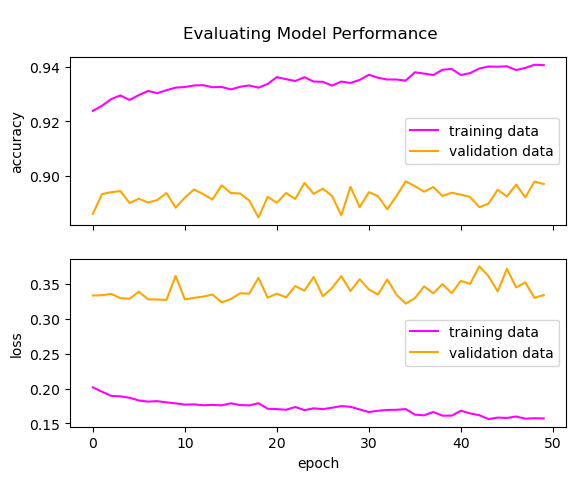

In [35]:
# Fit the cross-training validation model with 50 iterations; implement Early Stopping
from tensorflow.keras import callbacks
validate = model.fit(X_train, y_train, epochs=50, batch_size=128, 
                     # callbacks=callbacks.EarlyStopping(monitor='loss', patience=3),
                      verbose=0, validation_data=(X_valid, y_valid))

# Compare training and cross-training performance metrics
acc = validate.history['accuracy']           # training accuracy
val_acc = validate.history['val_accuracy']   # validation accuracy

loss = validate.history['loss']              # training loss
val_loss = validate.history['val_loss']      # validation loss

# Create subplot demonstration of model performance
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('\nEvaluating Model Performance')

# Demonstrate model accuracy between training & validation data :: goal is increased accuracy
axs[0].plot(acc, label='training data', color='magenta')
axs[0].plot(val_acc, label='validation data', color='orange')
axs[0].set(ylabel='accuracy')
axs[0].legend()

# Demonstrate model loss between training & validation data :: goal is decreased loss
axs[1].plot(loss, label='training data', color='magenta')
axs[1].plot(val_loss, label='validation data', color='orange')
axs[1].set(xlabel='epoch')
axs[1].set(ylabel='loss')
axs[1].legend();

---
### Predictive Analysis

In [37]:
# Assign a predicted output using X-test data on our model
y_pred = model.predict(X_test)

# # Report the accuracy of the predicted output against the actual y-test data
# from sklearn.metrics import accuracy_score
# print(f'Our model predicted the y-test values with {round(accuracy_score(y_pred, y_test)*100,2)}& accuracy.\n')

313/313 [==============================] - 1s 2ms/step



Our model predicts the following image should be labeled :: 9

Ankle boot


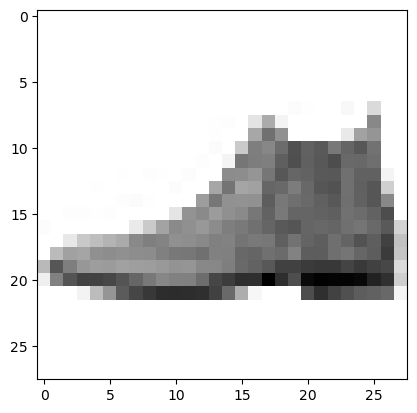

In [38]:
# Make a single prediction using our new model
print(f'\nOur model predicts the following image should be labeled :: {np.argmax(y_pred[0])}\n')
plt.imshow(X_test[0], cmap='binary')
print(label_descriptors[y_test[0]]);

In [44]:
# Prepare a confusion matrix of label predictions
y_pred_labels = [np.argmax(i) for i in y_pred]
print(labor_descriptors[y_pred_labels])

NameError: name 'labor_descriptors' is not defined

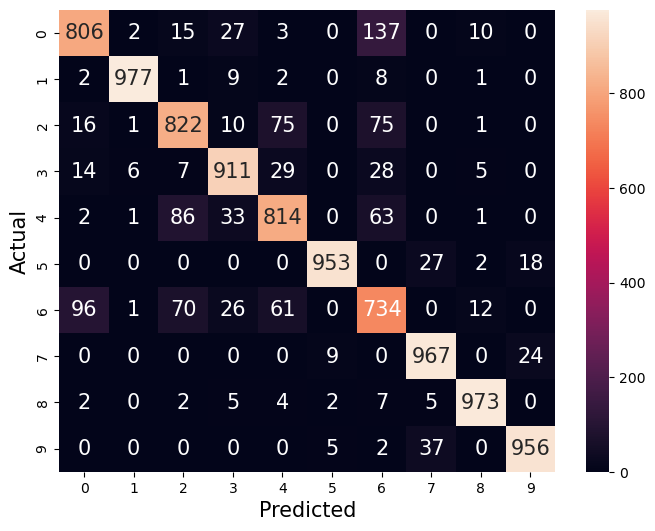

In [42]:
# Display a gradient-valued heatmap of the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_labels), annot=True, fmt='d', annot_kws={"size":15})
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual', fontsize=15);

In [43]:
# Observe the Classification Report of the Model's Performance Metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.82      0.82      1000
           3       0.89      0.91      0.90      1000
           4       0.82      0.81      0.82      1000
           5       0.98      0.95      0.97      1000
           6       0.70      0.73      0.71      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



**<center>Conclusion:**</center>
After much trial and error, we found our best performance to be in the utilization of 1-2 hidden layers in our neural network, with build parameters to include inner layer activation function 'Relu' for both layers of neuron size 512 and 128 respectively, with best fit hyperparameter tuning to include 'Adam' for our optimizer, 'Sparse Categorical Cross Entropy' for our loss function, and to implement 'Early Stopping' as a technique to ensure we will refrain from overfitting the data as much as possible.